In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#109747'
NONTARGET_COLOR = 'black'


CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache_M2_300'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023

stdfont = 14
stdyfrac = 0.06

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))#,'AE_267']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

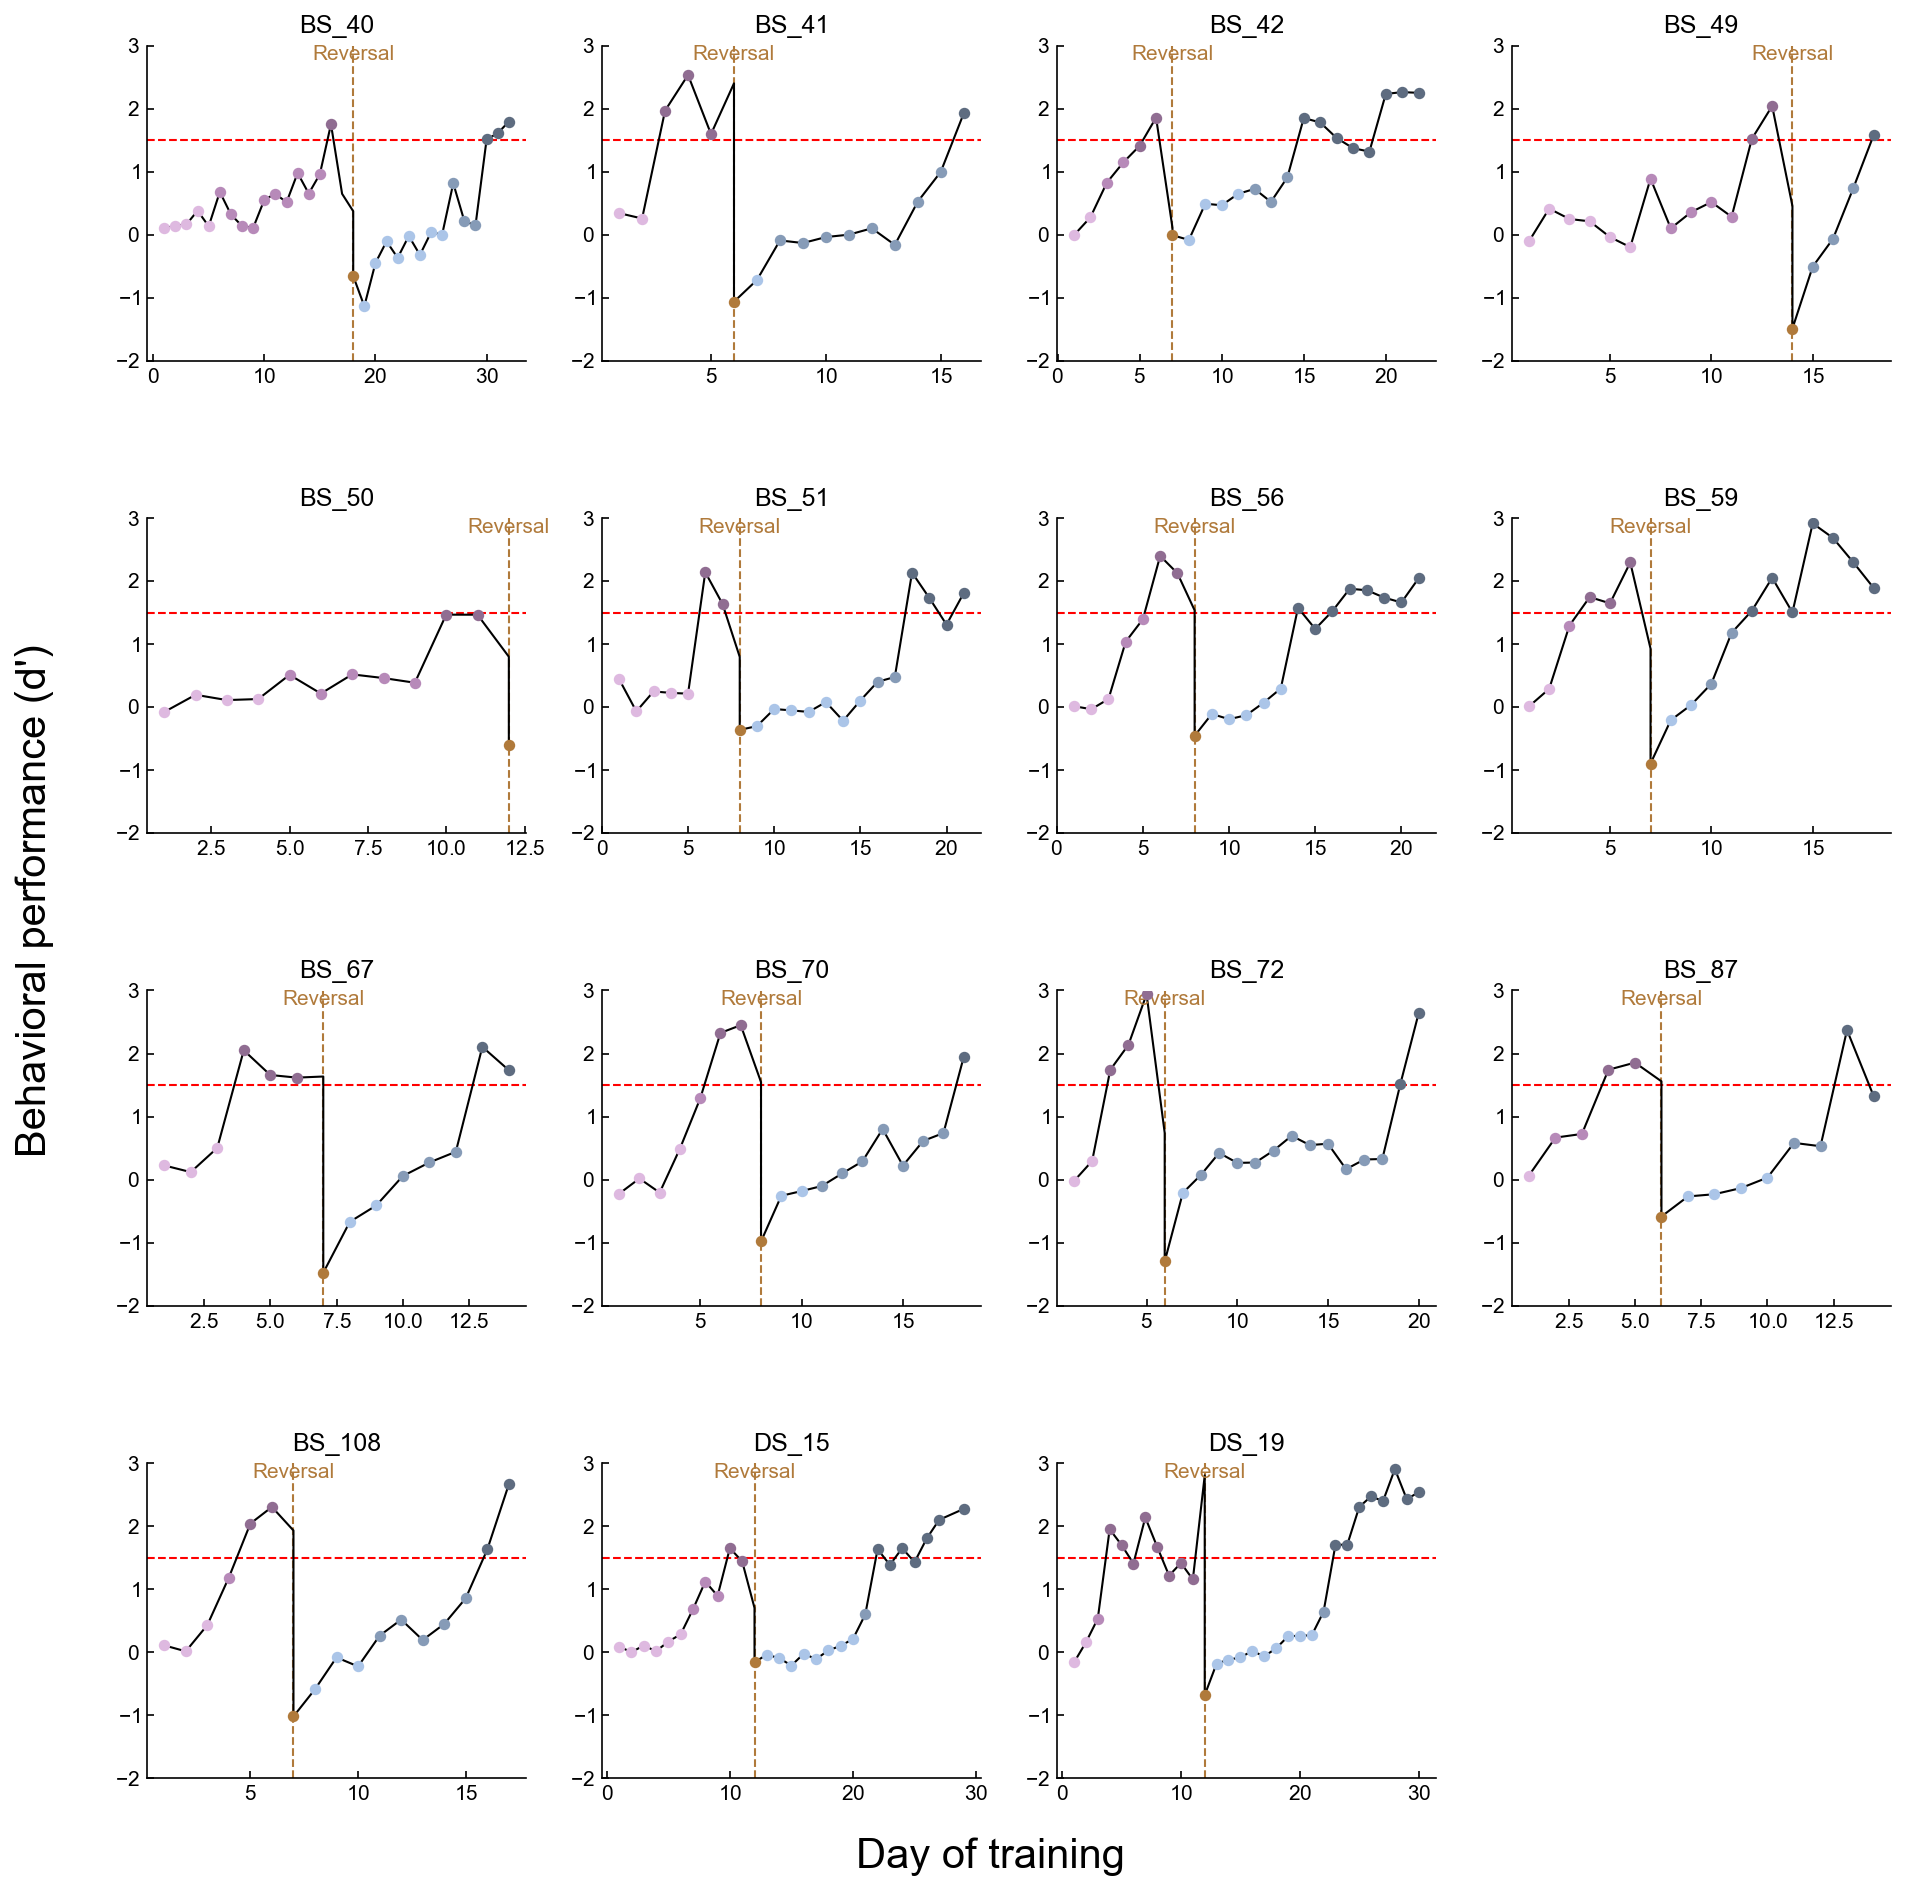

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'M2':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 554/554 [00:07<00:00, 77.00it/s] 


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1624/1624 [00:31<00:00, 51.58it/s] 

errors for: []


# NCR

In [7]:
Tuning_target_preearly = []
Tuning_target_prelate = []
Tuning_target_preexpert = []
Tuning_target_postearly = []
Tuning_target_postlate = []
Tuning_target_postexpert = []
Tuning_target_switch = []

Tuning_nontarget_preearly = []
Tuning_nontarget_prelate = []
Tuning_nontarget_preexpert = []
Tuning_nontarget_postearly = []
Tuning_nontarget_postlate = []
Tuning_nontarget_postexpert = []
Tuning_nontarget_switch = []

Tuning_index_preearly = []
Tuning_index_prelate = []
Tuning_index_preexpert = []
Tuning_index_postearly = []
Tuning_index_postlate = []
Tuning_index_postexpert = []
Tuning_index_switch = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        FR_target = sessionfile.responsiveness[clust]['target'].FR
        FR_bl_target = sessionfile.responsiveness[clust]['target'].FRbaseline
        FR_nontarget = sessionfile.responsiveness[clust]['nontarget'].FR
        FR_bl_nontarget = sessionfile.responsiveness[clust]['nontarget'].FRbaseline
        Tuning_target = (FR_target - FR_bl_target)# / FR_bl_target
        Tuning_nontarget = (FR_nontarget - FR_bl_nontarget)# / FR_bl_nontarget
        Tuning_index = (FR_target - FR_nontarget)# / (FR_target+FR_nontarget)
    except Exception as e:
        FRmod = np.nan
        Tuning_target = np.nan
        Tuning_nontarget = np.nan
        Tuning_index = np.nan
        print(e)
    
    if FRmod > 2.3:
        continue
        
    if EILphases[idx] == 'switch':
        Tuning_target_switch.append(Tuning_target)
        Tuning_nontarget_switch.append(Tuning_nontarget)
        Tuning_index_switch.append(Tuning_index)
#         Ramping_switch.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #preearly_animals.append(sessionfile.meta.animal)
    if EILphases[idx] == 'pre early':
        Tuning_target_preearly.append(Tuning_target)
        Tuning_nontarget_preearly.append(Tuning_nontarget)
        Tuning_index_preearly.append(Tuning_index)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        Tuning_target_prelate.append(Tuning_target)
        Tuning_nontarget_prelate.append(Tuning_nontarget)
        Tuning_index_prelate.append(Tuning_index)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        Tuning_target_preexpert.append(Tuning_target)
        Tuning_nontarget_preexpert.append(Tuning_nontarget)
        Tuning_index_preexpert.append(Tuning_index)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        Tuning_target_postearly.append(Tuning_target)
        Tuning_nontarget_postearly.append(Tuning_nontarget)
        Tuning_index_postearly.append(Tuning_index)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        Tuning_target_postlate.append(Tuning_target)
        Tuning_nontarget_postlate.append(Tuning_nontarget)
        Tuning_index_postlate.append(Tuning_index)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        Tuning_target_postexpert.append(Tuning_target)
        Tuning_nontarget_postexpert.append(Tuning_nontarget)
        Tuning_index_postexpert.append(Tuning_index)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

Tuning_target_preearly = np.array(ilep.rmnan(Tuning_target_preearly))
Tuning_target_prelate = np.array(ilep.rmnan(Tuning_target_prelate))
Tuning_target_preexpert = np.array(ilep.rmnan(Tuning_target_preexpert))
Tuning_target_postearly = np.array(ilep.rmnan(Tuning_target_postearly))
Tuning_target_postlate = np.array(ilep.rmnan(Tuning_target_postlate))
Tuning_target_postexpert = np.array(ilep.rmnan(Tuning_target_postexpert))

Tuning_nontarget_preearly = np.array(ilep.rmnan(Tuning_nontarget_preearly))
Tuning_nontarget_prelate = np.array(ilep.rmnan(Tuning_nontarget_prelate))
Tuning_nontarget_preexpert = np.array(ilep.rmnan(Tuning_nontarget_preexpert))
Tuning_nontarget_postearly = np.array(ilep.rmnan(Tuning_nontarget_postearly))
Tuning_nontarget_postlate = np.array(ilep.rmnan(Tuning_nontarget_postlate))
Tuning_nontarget_postexpert = np.array(ilep.rmnan(Tuning_nontarget_postexpert))

Tuning_index_preearly = np.array(ilep.rmnan(Tuning_index_preearly))
Tuning_index_prelate = np.array(ilep.rmnan(Tuning_index_prelate))
Tuning_index_preexpert = np.array(ilep.rmnan(Tuning_index_preexpert))
Tuning_index_postearly = np.array(ilep.rmnan(Tuning_index_postearly))
Tuning_index_postlate = np.array(ilep.rmnan(Tuning_index_postlate))
Tuning_index_postexpert = np.array(ilep.rmnan(Tuning_index_postexpert))

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

1624it [00:31, 51.72it/s] 


meta NOT subset; don't know how to subset; dropped


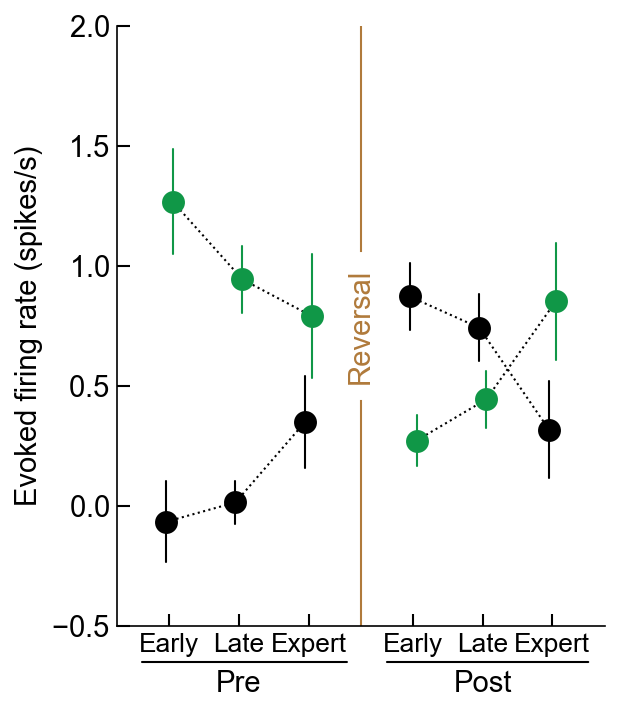

In [8]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([-0.5,2])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\M2\\M2 NCR Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [9]:
data_target_M2 = SimpleNamespace()
data_target_M2.preearly = Tuning_target_preearly
data_target_M2.prelate = Tuning_target_prelate
data_target_M2.preexpert = Tuning_target_preexpert
data_target_M2.postearly = Tuning_target_postearly
data_target_M2.postlate = Tuning_target_postlate
data_target_M2.postexpert = Tuning_target_postexpert

data_nontarget_M2 = SimpleNamespace()
data_nontarget_M2.preearly = Tuning_nontarget_preearly
data_nontarget_M2.prelate = Tuning_nontarget_prelate
data_nontarget_M2.preexpert = Tuning_nontarget_preexpert
data_nontarget_M2.postearly = Tuning_nontarget_postearly
data_nontarget_M2.postlate = Tuning_nontarget_postlate
data_nontarget_M2.postexpert = Tuning_nontarget_postexpert

In [10]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target_M2)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source           SS     DF         MS         F     p-unc  \
0            phase    78.020836    3.0  26.006945  9.006487  0.000007   
1          context     0.185038    1.0   0.185038  0.064081  0.800211   
2  phase * context    16.500666    3.0   5.500222  1.904786  0.127107   
3         Residual  2867.366294  993.0   2.887579       NaN       NaN   

        np2  
0  0.026489  
1  0.000065  
2  0.005722  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.035045  0.140181 -0.251986
8     post-late  baseline  experimental  0.254446  0.339262 -0.122829
9    pre-expert  baseline  experimental  0.930271  0.930271  0.077008
10     pre-late  baseline  experimental  0.140966  0.281931  0.177170
key preearly has 79 non-nan elements
key prelate has 158 non-nan elements
key preexpert has 83 non-nan elements
key postearly has 174 non-nan elements
key postlate has 141 non-nan elements
key postexpert has 67 no

In [11]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget_M2)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source           SS     DF         MS          F         p-unc  \
0            phase   117.588669    3.0  39.196223  16.364874  2.191584e-10   
1          context     0.209103    1.0   0.209103   0.087303  7.676960e-01   
2  phase * context    15.738128    3.0   5.246043   2.190283  8.761633e-02   
3         Residual  2373.587330  991.0   2.395144        NaN           NaN   

        np2  
0  0.047202  
1  0.000088  
2  0.006587  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.075084  0.150168  0.255122
8     post-late  baseline  experimental  0.499321  0.665761  0.073403
9    pre-expert  baseline  experimental  0.058985  0.150168 -0.243329
10     pre-late  baseline  experimental  0.917126  0.917126 -0.063755
key preearly has 79 non-nan elements
key prelate has 157 non-nan elements
key preexpert has 83 non-nan elements
key postearly has 174 non-nan elements
key postlate has 141 non-nan elements

# CR

In [1]:
Tuning_target_preearly = []
Tuning_target_prelate = []
Tuning_target_preexpert = []
Tuning_target_postearly = []
Tuning_target_postlate = []
Tuning_target_postexpert = []
Tuning_target_switch = []

Tuning_nontarget_preearly = []
Tuning_nontarget_prelate = []
Tuning_nontarget_preexpert = []
Tuning_nontarget_postearly = []
Tuning_nontarget_postlate = []
Tuning_nontarget_postexpert = []
Tuning_nontarget_switch = []

Tuning_index_preearly = []
Tuning_index_prelate = []
Tuning_index_preexpert = []
Tuning_index_postearly = []
Tuning_index_postlate = []
Tuning_index_postexpert = []
Tuning_index_switch = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        FR_target = sessionfile.responsiveness[clust]['target'].FR
        FR_bl_target = sessionfile.responsiveness[clust]['target'].FRbaseline
        FR_nontarget = sessionfile.responsiveness[clust]['nontarget'].FR
        FR_bl_nontarget = sessionfile.responsiveness[clust]['nontarget'].FRbaseline
        Tuning_target = (FR_target - FR_bl_target)# / FR_bl_target
        Tuning_nontarget = (FR_nontarget - FR_bl_nontarget)# / FR_bl_nontarget
        Tuning_index = (FR_target - FR_nontarget)# / (FR_target+FR_nontarget)
    except Exception as e:
        FRmod = np.nan
        Tuning_target = np.nan
        Tuning_nontarget = np.nan
        Tuning_index = np.nan
        print(e)
    
    if FRmod < 2.3:
        continue
        
    if EILphases[idx] == 'switch':
        Tuning_target_switch.append(Tuning_target)
        Tuning_nontarget_switch.append(Tuning_nontarget)
        Tuning_index_switch.append(Tuning_index)
#         Ramping_switch.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #preearly_animals.append(sessionfile.meta.animal)
    if EILphases[idx] == 'pre early':
        Tuning_target_preearly.append(Tuning_target)
        Tuning_nontarget_preearly.append(Tuning_nontarget)
        Tuning_index_preearly.append(Tuning_index)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        Tuning_target_prelate.append(Tuning_target)
        Tuning_nontarget_prelate.append(Tuning_nontarget)
        Tuning_index_prelate.append(Tuning_index)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        Tuning_target_preexpert.append(Tuning_target)
        Tuning_nontarget_preexpert.append(Tuning_nontarget)
        Tuning_index_preexpert.append(Tuning_index)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        Tuning_target_postearly.append(Tuning_target)
        Tuning_nontarget_postearly.append(Tuning_nontarget)
        Tuning_index_postearly.append(Tuning_index)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        Tuning_target_postlate.append(Tuning_target)
        Tuning_nontarget_postlate.append(Tuning_nontarget)
        Tuning_index_postlate.append(Tuning_index)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        Tuning_target_postexpert.append(Tuning_target)
        Tuning_nontarget_postexpert.append(Tuning_nontarget)
        Tuning_index_postexpert.append(Tuning_index)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

Tuning_target_preearly = np.array(ilep.rmnan(Tuning_target_preearly))
Tuning_target_prelate = np.array(ilep.rmnan(Tuning_target_prelate))
Tuning_target_preexpert = np.array(ilep.rmnan(Tuning_target_preexpert))
Tuning_target_postearly = np.array(ilep.rmnan(Tuning_target_postearly))
Tuning_target_postlate = np.array(ilep.rmnan(Tuning_target_postlate))
Tuning_target_postexpert = np.array(ilep.rmnan(Tuning_target_postexpert))

Tuning_nontarget_preearly = np.array(ilep.rmnan(Tuning_nontarget_preearly))
Tuning_nontarget_prelate = np.array(ilep.rmnan(Tuning_nontarget_prelate))
Tuning_nontarget_preexpert = np.array(ilep.rmnan(Tuning_nontarget_preexpert))
Tuning_nontarget_postearly = np.array(ilep.rmnan(Tuning_nontarget_postearly))
Tuning_nontarget_postlate = np.array(ilep.rmnan(Tuning_nontarget_postlate))
Tuning_nontarget_postexpert = np.array(ilep.rmnan(Tuning_nontarget_postexpert))

Tuning_index_preearly = np.array(ilep.rmnan(Tuning_index_preearly))
Tuning_index_prelate = np.array(ilep.rmnan(Tuning_index_prelate))
Tuning_index_preexpert = np.array(ilep.rmnan(Tuning_index_preexpert))
Tuning_index_postearly = np.array(ilep.rmnan(Tuning_index_postearly))
Tuning_index_postlate = np.array(ilep.rmnan(Tuning_index_postlate))
Tuning_index_postexpert = np.array(ilep.rmnan(Tuning_index_postexpert))

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

NameError: name 'tqdm' is not defined

In [13]:
CRe_Tuning_target_preearly = Tuning_target_preearly[Tuning_target_preearly>0]
CRe_Tuning_target_prelate = Tuning_target_prelate[Tuning_target_prelate>0]
CRe_Tuning_target_preexpert = Tuning_target_preexpert[Tuning_target_preexpert>0]
CRe_Tuning_target_postearly = Tuning_target_postearly[Tuning_target_postearly>0]
CRe_Tuning_target_postlate = Tuning_target_postlate[Tuning_target_postlate>0]
CRe_Tuning_target_postexpert = Tuning_target_postexpert[Tuning_target_postexpert>0]

CRs_Tuning_target_preearly = Tuning_target_preearly[Tuning_target_preearly<0]
CRs_Tuning_target_prelate = Tuning_target_prelate[Tuning_target_prelate<0]
CRs_Tuning_target_preexpert = Tuning_target_preexpert[Tuning_target_preexpert<0]
CRs_Tuning_target_postearly = Tuning_target_postearly[Tuning_target_postearly<0]
CRs_Tuning_target_postlate = Tuning_target_postlate[Tuning_target_postlate<0]
CRs_Tuning_target_postexpert = Tuning_target_postexpert[Tuning_target_postexpert<0]

In [14]:
CRe_Tuning_nontarget_preearly = Tuning_nontarget_preearly[Tuning_nontarget_preearly>0]
CRe_Tuning_nontarget_prelate = Tuning_nontarget_prelate[Tuning_nontarget_prelate>0]
CRe_Tuning_nontarget_preexpert = Tuning_nontarget_preexpert[Tuning_nontarget_preexpert>0]
CRe_Tuning_nontarget_postearly = Tuning_nontarget_postearly[Tuning_nontarget_postearly>0]
CRe_Tuning_nontarget_postlate = Tuning_nontarget_postlate[Tuning_nontarget_postlate>0]
CRe_Tuning_nontarget_postexpert = Tuning_nontarget_postexpert[Tuning_nontarget_postexpert>0]

CRs_Tuning_nontarget_preearly = Tuning_nontarget_preearly[Tuning_nontarget_preearly<0]
CRs_Tuning_nontarget_prelate = Tuning_nontarget_prelate[Tuning_nontarget_prelate<0]
CRs_Tuning_nontarget_preexpert = Tuning_nontarget_preexpert[Tuning_nontarget_preexpert<0]
CRs_Tuning_nontarget_postearly = Tuning_nontarget_postearly[Tuning_nontarget_postearly<0]
CRs_Tuning_nontarget_postlate = Tuning_nontarget_postlate[Tuning_nontarget_postlate<0]
CRs_Tuning_nontarget_postexpert = Tuning_nontarget_postexpert[Tuning_nontarget_postexpert<0]

In [15]:
print(len(CRe_Tuning_target_preearly) + len(CRs_Tuning_target_preearly))
print(len(CRe_Tuning_target_prelate) + len(CRs_Tuning_target_prelate))
print(len(CRe_Tuning_target_preexpert) + len(CRs_Tuning_target_preexpert))
print(len(CRe_Tuning_target_postearly) + len(CRs_Tuning_target_postearly))
print(len(CRe_Tuning_target_postlate) + len(CRs_Tuning_target_postlate))
print(len(CRe_Tuning_target_postexpert) + len(CRs_Tuning_target_postexpert))

print(len(Tuning_target_preearly))
print(len(Tuning_target_prelate))
print(len(Tuning_target_preexpert))
print(len(Tuning_target_postearly))
print(len(Tuning_target_postlate))
print(len(Tuning_target_postexpert))

80
81
100
132
106
113
80
81
100
132
106
113


In [16]:
print(len(CRe_Tuning_nontarget_preearly) + len(CRs_Tuning_nontarget_preearly))
print(len(CRe_Tuning_nontarget_prelate) + len(CRs_Tuning_nontarget_prelate))
print(len(CRe_Tuning_nontarget_preexpert) + len(CRs_Tuning_nontarget_preexpert))
print(len(CRe_Tuning_nontarget_postearly) + len(CRs_Tuning_nontarget_postearly))
print(len(CRe_Tuning_nontarget_postlate) + len(CRs_Tuning_nontarget_postlate))
print(len(CRe_Tuning_nontarget_postexpert) + len(CRs_Tuning_nontarget_postexpert))

80
81
99
132
106
113


In [17]:
print(len(Tuning_nontarget_preearly))
print(len(Tuning_nontarget_prelate))
print(len(Tuning_nontarget_preexpert))
print(len(Tuning_nontarget_postearly))
print(len(Tuning_nontarget_postlate))
print(len(Tuning_nontarget_postexpert))

80
81
99
132
106
113


## CR evoked

meta NOT subset; don't know how to subset; dropped


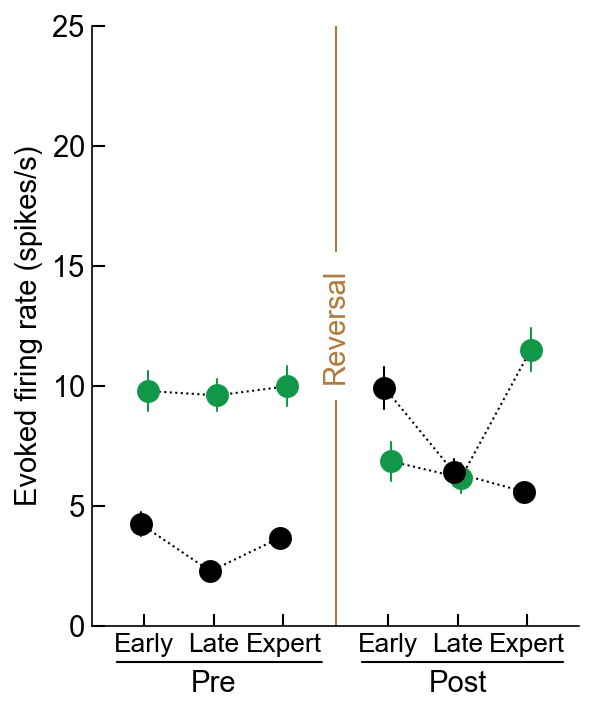

In [18]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [CRe_Tuning_target_preearly,CRe_Tuning_target_prelate,CRe_Tuning_target_preexpert,CRe_Tuning_target_postearly,CRe_Tuning_target_postlate,CRe_Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [CRe_Tuning_nontarget_preearly,CRe_Tuning_nontarget_prelate,CRe_Tuning_nontarget_preexpert,CRe_Tuning_nontarget_postearly,CRe_Tuning_nontarget_postlate,CRe_Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,25])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\M2\\M2 CR_e Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

## CR supp

meta NOT subset; don't know how to subset; dropped


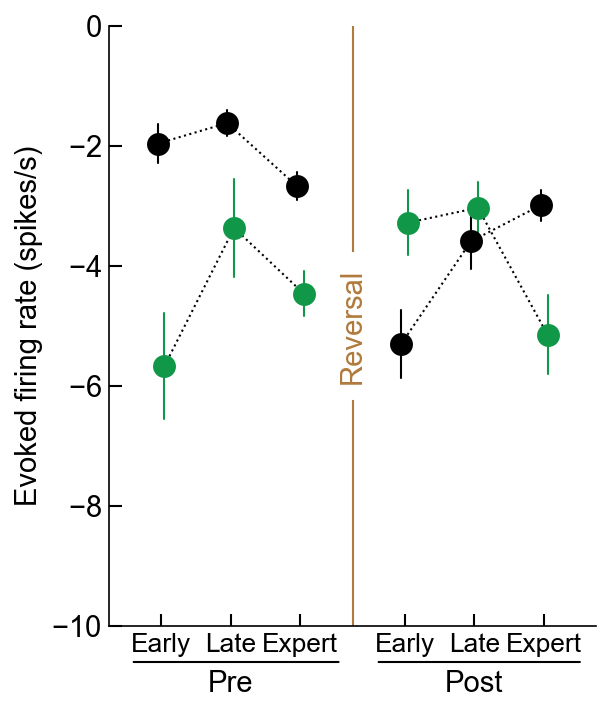

In [19]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [CRs_Tuning_target_preearly,CRs_Tuning_target_prelate,CRs_Tuning_target_preexpert,CRs_Tuning_target_postearly,CRs_Tuning_target_postlate,CRs_Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [CRs_Tuning_nontarget_preearly,CRs_Tuning_nontarget_prelate,CRs_Tuning_nontarget_preexpert,CRs_Tuning_nontarget_postearly,CRs_Tuning_nontarget_postlate,CRs_Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([-10,0])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\M2\\M2 CR_s Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [20]:
7.902128e-01 

0.7902128

In [21]:
data_target_M2_e = SimpleNamespace()
data_target_M2_e.preearly = CRe_Tuning_target_preearly
data_target_M2_e.prelate = CRe_Tuning_target_prelate
data_target_M2_e.preexpert = CRe_Tuning_target_preexpert
data_target_M2_e.postearly = CRe_Tuning_target_postearly
data_target_M2_e.postlate = CRe_Tuning_target_postlate
data_target_M2_e.postexpert = CRe_Tuning_target_postexpert

data_nontarget_M2_e = SimpleNamespace()
data_nontarget_M2_e.preearly = CRe_Tuning_nontarget_preearly
data_nontarget_M2_e.prelate = CRe_Tuning_nontarget_prelate
data_nontarget_M2_e.preexpert = CRe_Tuning_nontarget_preexpert
data_nontarget_M2_e.postearly = CRe_Tuning_nontarget_postearly
data_nontarget_M2_e.postlate = CRe_Tuning_nontarget_postlate
data_nontarget_M2_e.postexpert = CRe_Tuning_nontarget_postexpert

In [22]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target_M2_e)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS     DF          MS         F     p-unc  \
0            phase   1261.546159    3.0  420.515386  7.934365  0.000033   
1          context    304.828447    1.0  304.828447  5.751561  0.016729   
2  phase * context   1119.022101    3.0  373.007367  7.037974  0.000115   
3         Residual  37894.464646  715.0   52.999251       NaN       NaN   

        np2  
0  0.032218  
1  0.007980  
2  0.028683  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  4.149661e-10  1.659864e-09 -0.693473
8     post-late  baseline  experimental  4.372179e-01  7.902128e-01  0.088548
9    pre-expert  baseline  experimental  9.004779e-01  9.004779e-01 -0.054901
10     pre-late  baseline  experimental  5.926596e-01  7.902128e-01  0.027405
key preearly has 75 non-nan elements
key prelate has 79 non-nan elements
key preexpert has 85 non-nan elements
key postearly has 113 non-nan elements
key postlate 

In [23]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget_M2_e)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS     DF           MS          F         p-unc  \
0            phase   3181.068074    3.0  1060.356025  35.499634  2.613188e-21   
1          context    351.410223    1.0   351.410223  11.764854  6.403992e-04   
2  phase * context    539.883118    3.0   179.961039   6.024911  4.723581e-04   
3         Residual  20132.037365  674.0    29.869492        NaN           NaN   

        np2  
0  0.136450  
1  0.017156  
2  0.026117  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.275606  0.275606  0.169784
8     post-late  baseline  experimental  0.000091  0.000121  0.442681
9    pre-expert  baseline  experimental  0.000080  0.000121 -0.506325
10     pre-late  baseline  experimental  0.000002  0.000006  0.636052
key preearly has 62 non-nan elements
key prelate has 66 non-nan elements
key preexpert has 71 non-nan elements
key postearly has 120 non-nan elements
key postlate has 97 non

In [24]:
import scipy


In [25]:
data_target_M2_s = SimpleNamespace()
data_target_M2_s.preearly = CRs_Tuning_target_preearly
data_target_M2_s.prelate = CRs_Tuning_target_prelate
data_target_M2_s.preexpert = CRs_Tuning_target_preexpert
data_target_M2_s.postearly = CRs_Tuning_target_postearly
data_target_M2_s.postlate = CRs_Tuning_target_postlate
data_target_M2_s.postexpert = CRs_Tuning_target_postexpert

data_nontarget_M2_s = SimpleNamespace()
data_nontarget_M2_s.preearly = CRs_Tuning_nontarget_preearly
data_nontarget_M2_s.prelate = CRs_Tuning_nontarget_prelate
data_nontarget_M2_s.preexpert = CRs_Tuning_nontarget_preexpert
data_nontarget_M2_s.postearly = CRs_Tuning_nontarget_postearly
data_nontarget_M2_s.postlate = CRs_Tuning_nontarget_postlate
data_nontarget_M2_s.postexpert = CRs_Tuning_nontarget_postexpert

In [26]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target_M2_s)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source          SS    DF         MS         F     p-unc       np2
0            phase   23.988243   3.0   7.996081  2.213052  0.094490  0.088950
1          context    5.227815   1.0   5.227815  1.446887  0.233200  0.020834
2  phase * context   30.144859   3.0  10.048286  2.781035  0.047553  0.109284
3         Residual  245.693910  68.0   3.613146       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.016956  0.067822  1.019248
8     post-late  baseline  experimental  0.872416  0.872416 -0.116697
9    pre-expert  baseline  experimental  0.294118  0.392157  0.736105
10     pre-late  baseline  experimental  0.190476  0.380952 -1.056198
key preearly has 5 non-nan elements
key prelate has 2 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 19 non-nan elements
key postlate has 10 non-nan elements
key postexpert has 13 non-nan elements


In [27]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget_M2_s)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source          SS     DF         MS          F         p-unc  \
0            phase  110.929157    3.0  36.976386  22.932294  1.458890e-11   
1          context    0.632843    1.0   0.632843   0.392481  5.323199e-01   
2  phase * context   27.755601    3.0   9.251867   5.737893  1.110188e-03   
3         Residual  174.140873  108.0   1.612415        NaN           NaN   

        np2  
0  0.389129  
1  0.003621  
2  0.137474  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.391267  0.503543 -0.507649
8     post-late  baseline  experimental  0.036040  0.072080 -0.931208
9    pre-expert  baseline  experimental  0.004144  0.016576  0.918176
10     pre-late  baseline  experimental  0.503543  0.503543 -0.286982
key preearly has 18 non-nan elements
key prelate has 15 non-nan elements
key preexpert has 28 non-nan elements
key postearly has 12 non-nan elements
key postlate has 9 non-nan elements
key post

# old

In [ ]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [Tuning_index_preearly,Tuning_index_prelate,Tuning_index_preexpert,Tuning_index_postearly,Tuning_index_postlate,Tuning_index_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
# X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=1,zorder=-10,clip_on=False)
# ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-1.025,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ylab = ax.set_ylabel('Tuning index')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Tuning index over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [ ]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(Tuning_index_preearly)
data_dec.prelate = np.abs(Tuning_index_prelate)
data_dec.preexpert = np.abs(Tuning_index_preexpert)
data_dec.postearly = np.abs(Tuning_index_postearly)
data_dec.postlate = np.abs(Tuning_index_postlate)
data_dec.postexpert = np.abs(Tuning_index_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

In [ ]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Target-nontarget tuning over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [ ]:
# data_target = SimpleNamespace()
# data_target.preearly = np.abs(Tuning_target_preearly)
# data_target.prelate = np.abs(Tuning_target_prelate)
# data_target.preexpert = np.abs(Tuning_target_preexpert)
# data_target.postearly = np.abs(Tuning_target_postearly)
# data_target.postlate = np.abs(Tuning_target_postlate)
# data_target.postexpert = np.abs(Tuning_target_postexpert)

# data_nontarget = SimpleNamespace()
# data_nontarget.preearly = np.abs(Tuning_nontarget_preearly)
# data_nontarget.prelate = np.abs(Tuning_nontarget_prelate)
# data_nontarget.preexpert = np.abs(Tuning_nontarget_preexpert)
# data_nontarget.postearly = np.abs(Tuning_nontarget_postearly)
# data_nontarget.postlate = np.abs(Tuning_nontarget_postlate)
# data_nontarget.postexpert = np.abs(Tuning_nontarget_postexpert)

data_target = SimpleNamespace()
data_target.preearly = Tuning_target_preearly
data_target.prelate = Tuning_target_prelate
data_target.preexpert = Tuning_target_preexpert
data_target.postearly = Tuning_target_postearly
data_target.postlate = Tuning_target_postlate
data_target.postexpert = Tuning_target_postexpert

data_nontarget = SimpleNamespace()
data_nontarget.preearly = Tuning_nontarget_preearly
data_nontarget.prelate = Tuning_nontarget_prelate
data_nontarget.preexpert = Tuning_nontarget_preexpert
data_nontarget.postearly = Tuning_nontarget_postearly
data_nontarget.postlate = Tuning_nontarget_postlate
data_nontarget.postexpert = Tuning_nontarget_postexpert

ilep.nonparametricIndependentStatsCompareToOther(data_target,data_nontarget)

In [ ]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target)

In [ ]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget)

In [ ]:
print(np.median(Tuning_target_preearly))
print(np.median(Tuning_target_prelate))
print(np.median(Tuning_target_preexpert))
print(np.median(Tuning_target_postearly))
print(np.median(Tuning_target_postlate))
print(np.median(Tuning_target_postexpert))

In [ ]:
[len(n) for n in [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]]

In [ ]:
[len(n) for n in [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]]

In [ ]:
np.sum([len(n) for n in [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]])